### Library imports

In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt

### Open file and split into seperate games
#### and show example game

In [2]:
file = open("EricRosen.txt")
text = file.read()
games = re.split('\n\n\n',text)[:-1]
print(games[1])

[Event "Casual Chess960 game"]
[Site "https://lichess.org/OK3IJFR4"]
[Date "2019.12.08"]
[Round "-"]
[White "baleful"]
[Black "EricRosen"]
[Result "0-1"]
[UTCDate "2019.12.08"]
[UTCTime "18:45:20"]
[WhiteElo "1625"]
[BlackElo "2074"]
[BlackTitle "IM"]
[Variant "Chess960"]
[TimeControl "180+2"]
[ECO "?"]
[Termination "Normal"]
[FEN "qrnbkrbn/pppppppp/8/8/8/8/PPPPPPPP/QRNBKRBN w KQkq - 0 1"]
[SetUp "1"]

1. f4 b5 2. Rf3 Ng6 3. g3 f6 4. Nf2 Bd5 5. e4 Bxe4 6. Nxe4 Qxe4+ 7. Be2 Qxc2 8. Nd3 Nd6 9. Rc1 Qa4 10. b3 Qa5 11. Bc5 Ne4 12. b4 Qa6 13. Re3 d5 14. Bf3 Qb7 15. Qd4 e5 16. fxe5 fxe5 17. Nxe5 Bf6 18. Bxe4 O-O-O 19. Bf5+ Kb8 20. Bxa7+ Ka8 21. Bxg6 hxg6 22. Ra3 Bxe5 23. Qxe5 Rfe8 24. Bb6+ Kb8 25. Bxc7+ Qxc7 26. Rxc7 Rxe5+ 27. Kf2 Kxc7 28. Ra8 Rxa8 0-1


### Extract metadata rows and turn it into a a list of dictionaries
##### E.g: "Event" : "Casual Blitz game", " Date" : "2019.12.08", ... for every game

In [3]:
metaDataRegex = re.compile('(\w+) "(.*)"', re.MULTILINE)
movesRegex = re.compile(']\n\n(.*) [012/\-]{3,}')
metaData = []
moves = []

for game in games:
    moves.append(re.search(movesRegex, game).group(1))
    gameData = {}
    for (key, value) in re.findall(metaDataRegex, game):
        gameData[key] = value
    metaData.append(gameData.copy())

### Create pandas dataframe of the data for ultimate data science

In [4]:
columns = list(metaData[max([len(x) for x in metaData])].keys())
d = pd.DataFrame(metaData, columns = columns)

In [5]:
d.head()

,Event,Site,Date,Round,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,WhiteTitle,Variant,TimeControl,ECO,Termination
0,Casual Blitz game,https://lichess.org/FKFHeB0u,2019.12.08,-,EricRosen,chessonmars,1-0,2019.12.08,18:55:49,2535,1665,NaN,NaN,IM,Standard,300+3,A00,Normal
1,Casual Chess960 game,https://lichess.org/OK3IJFR4,2019.12.08,-,baleful,EricRosen,0-1,2019.12.08,18:45:20,1625,2074,NaN,NaN,NaN,Chess960,180+2,?,Normal
2,Casual Blitz game,https://lichess.org/VVcCr4kA,2019.12.08,-,Bein_Jon,EricRosen,0-1,2019.12.08,18:35:55,1045,2535,NaN,NaN,NaN,Standard,300+0,A02,Normal
3,Casual Blitz game,https://lichess.org/fCy6d9P1,2019.12.08,-,EricRosen,NiSyndrome,1-0,2019.12.08,18:25:14,2535,1348,NaN,NaN,IM,Standard,300+0,C67,Normal
4,Casual Blitz game,https://lichess.org/jUUENSD5,2019.12.08,-,EricRosen,TARAKS,1-0,2019.12.08,18:17:10,2535,1094,NaN,NaN,IM,Standard,300+3,C36,Normal


### Define functions to create more columns in the dataframe

In [6]:
def isWin(game):
    if game['Result'] == "1/2-1/2":
        return "Draw"
    elif (game['Result'] == "1-0" and game['White'] == "EricRosen") or \
       (game['Result'] == "0-1" and game['Black'] == "EricRosen"):
        return "Win"
    return "Loss"

def nrMoves(move):
    return move.count('.')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def getYear(game):
    return game['Date'].split('.')[0]

def getMonth(game):
    return months[int(game['Date'].split('.')[1])-1]

def CSTtime(game):
    return (int(game['UTCTime'].split(':')[0])-6)%24 #CST is UTC-6 hours

### Add columns with data derived by those functions

In [7]:
d['Outcome'] = d.apply(isWin, axis=1)
d['NrMoves'] = [nrMoves(m) for m in moves]
d['Moves'] = moves
d['Year'] = d.apply(getYear, axis=1)
d['Month'] = d.apply(getMonth, axis=1)
d['CSTHour'] = d.apply(CSTtime, axis=1)

## FUN TIME

In [8]:
value_counts = d.Outcome.value_counts()
print(len(d),"total games")
print(value_counts)
print(str.format('\n{:.2f}% win rate',value_counts['Win']/value_counts.sum()*100))

14619 total games
Win     10365
Loss     3645
Draw      609
Name: Outcome, dtype: int64

70.90% win rate


### Nr of moves analyses

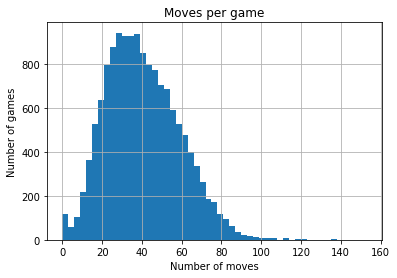

In [9]:
d.NrMoves.hist(bins=51);
plt.title('Moves per game');
plt.xlabel("Number of moves");
plt.ylabel("Number of games");

In [10]:
wins = d.loc[d.Outcome == "Win"]
losses = d.loc[d.Outcome == "Loss"]

In [11]:
print('Wins:\n', wins.NrMoves.describe(),'\n\n')
print('Losses:\n',losses.NrMoves.describe())

Wins:
 count    10365.000000
mean        36.862518
std         17.234867
min          0.000000
25%         24.000000
50%         35.000000
75%         48.000000
max        153.000000
Name: NrMoves, dtype: float64 


Losses:
 count    3645.000000
mean       45.796982
std        17.590067
min         0.000000
25%        33.000000
50%        46.000000
75%        58.000000
max       136.000000
Name: NrMoves, dtype: float64


### Flagging

In [12]:
flags = d.loc[d.Termination == "Time forfeit"]

In [13]:
n_flags = flags.NrMoves.count()
flag_wins = len(flags.loc[flags.Outcome == "Win"])
flag_losses = len(flags.loc[flags.Outcome == "Loss"])
flag_draws = len(flags.loc[flags.Outcome == "Draw"])

In [14]:
print(str.format('Games ended by flagging ({}):\n{} wins ({:.1f}%)\n{} losses ({:.1f}%)\n{} draws \
({:.1f}%) ??', n_flags, flag_wins, flag_wins/n_flags*100, flag_losses, flag_losses/n_flags*100, flag_draws, \
                 flag_draws/n_flags*100))

Games ended by flagging (5068):
3839 wins (75.7%)
1075 losses (21.2%)
154 draws (3.0%) ??


### Date & Time vs. Activity

In [15]:
#2015.06 -> 2019.12
years = (12*['2015'])+(12*['2016'])+(12*['2017'])+(12*['2018'])+(12*['2019'])[5:]
months = (5*['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])[5:]
xs = ['{}, {}'.format(months[i], years[i]) for i in range(len(years))]

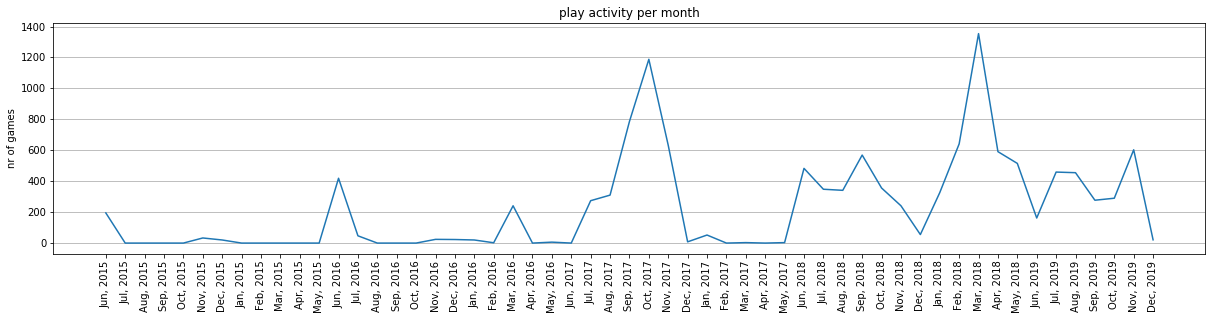

In [16]:
plt.figure(figsize=(8, 4));
plt.axes([0, 0.6, 2, .8]);
plt.plot(xs, [len(d[(d.Month==months[i]) & (d.Year==years[i])]) for i in range(len(years))]);
plt.xticks(rotation='vertical');
plt.title("play activity per month");
plt.ylabel("nr of games");
plt.grid(axis='y');

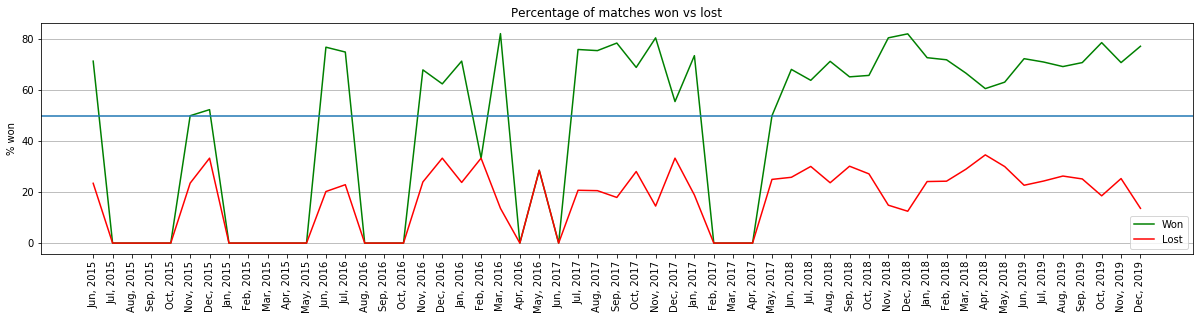

In [17]:
plt.figure(figsize=(8, 4));
plt.axes([0, 0.6, 2, .8]);
plt.plot(xs, [len(d[(d.Month==months[i]) & (d.Year==years[i]) & (d.Outcome=="Win")])/ \
              (len(d[(d.Month==months[i]) & (d.Year==years[i])])+1)*100 for i in range(len(years))], 'g');
plt.plot(xs, [len(d[(d.Month==months[i]) & (d.Year==years[i]) & (d.Outcome=="Loss")])/ \
              (len(d[(d.Month==months[i]) & (d.Year==years[i])])+1)*100 for i in range(len(years))], 'r');
plt.xticks(rotation='vertical');
plt.axhline(y=50)
plt.title("Percentage of matches won vs lost");
plt.legend(['Won', 'Lost'])
plt.ylabel("% won");
plt.grid(axis='y');

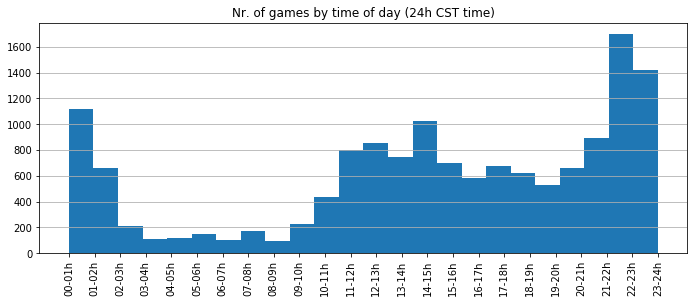

In [18]:
plt.axes([0, 0.6, 1.5, .8]);
d.CSTHour.hist(bins=24, grid=False);
plt.grid(axis='y')
plt.xticks(range(24), map(lambda x: str.format('{:02}-{:02}h',x,x+1), range(24)), rotation='vertical')
plt.title('Nr. of games by time of day (24h CST time)');
